**Time Series Analysis and Forecasting: APPLE STOCK**


In [ ]:
library(lubridate)
library(forecast)  
library(MLmetrics) 
library(ggplot2) 
library(tidyr)   
library(zoo)  
library(tseries)

# Data Loading :

In [7]:
# Read data
AAPL <- read.csv("/kaggle/input/applea/AAPL.csv")

head(AAPL)

,Date,Open,High,Low,Close,Adj.Close,Volume
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
2,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
3,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
4,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
5,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
6,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098436,48630400


In [8]:
summary(AAPL)

     Date                Open                High                Low           
 Length:10468       Min.   :  0.04966   Min.   :  0.04966   Min.   :  0.04911  
 Class :character   1st Qu.:  0.28348   1st Qu.:  0.28929   1st Qu.:  0.27679  
 Mode  :character   Median :  0.47411   Median :  0.48277   Median :  0.46596  
                    Mean   : 14.75799   Mean   : 14.92149   Mean   : 14.59448  
                    3rd Qu.: 14.95330   3rd Qu.: 15.05714   3rd Qu.: 14.69259  
                    Max.   :182.63001   Max.   :182.94000   Max.   :179.11999  
     Close             Adj.Close             Volume         
 Min.   :  0.04911   Min.   :  0.03833   Min.   :0.000e+00  
 1st Qu.:  0.28348   1st Qu.:  0.23546   1st Qu.:1.238e+08  
 Median :  0.47545   Median :  0.39237   Median :2.182e+08  
 Mean   : 14.76353   Mean   : 14.13043   Mean   :3.308e+08  
 3rd Qu.: 14.90196   3rd Qu.: 12.83527   3rd Qu.:4.106e+08  
 Max.   :182.01000   Max.   :181.51170   Max.   :7.422e+09  

# We changed Date to datatype. Select the columns (Date, Close). to make it appears sequentially :

In [9]:
AAPL <- AAPL %>% 
  mutate(Date = ymd(Date)) %>% 
  select(c(Date, Close)) %>% 
  complete(Date = seq.Date(min(Date), max(Date), by="day")) %>% 
  arrange()

head(AAPL)


Date,Close
<date>,<dbl>
1980-12-12,0.128348
1980-12-13,NA
1980-12-14,NA
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513


# check if the data has missing value :

In [10]:
AAPL %>% is.na() %>% colSums()

Date Close 
    0  4695

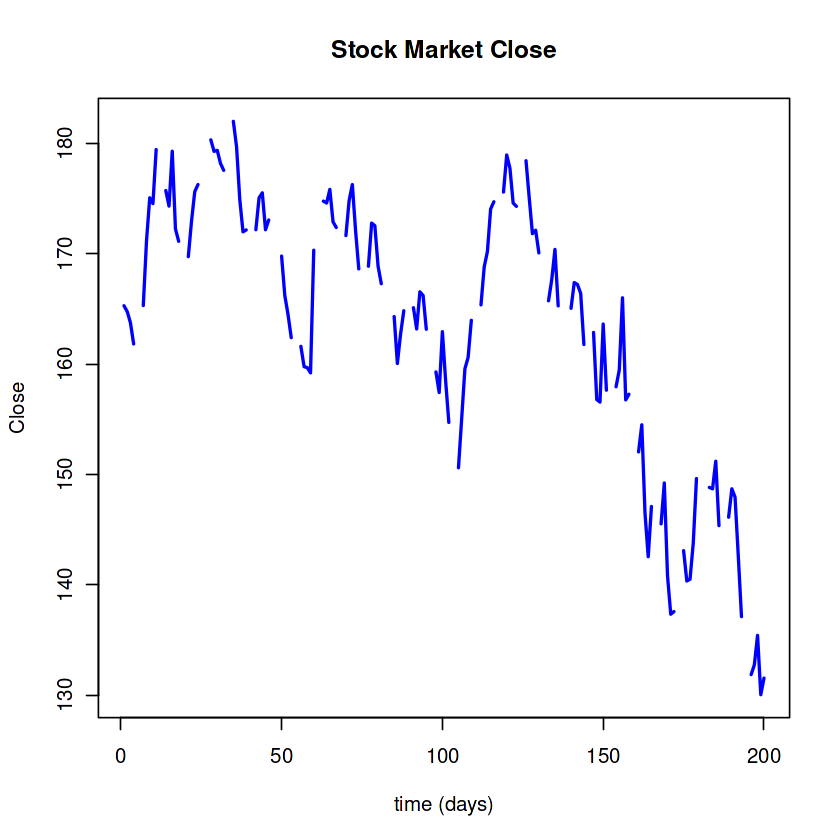

In [11]:
AAPL$Close %>% tail(200) %>% 
  plot(type="l",
       col = "blue",
       lwd = 2,
       xlab = "time (days)",
       ylab = 'Close',
       main = "Stock Market Close")

#### **->We can not use the data like that. Because time series data must appear sequentially.**

# Fill the missing value with "extend" :

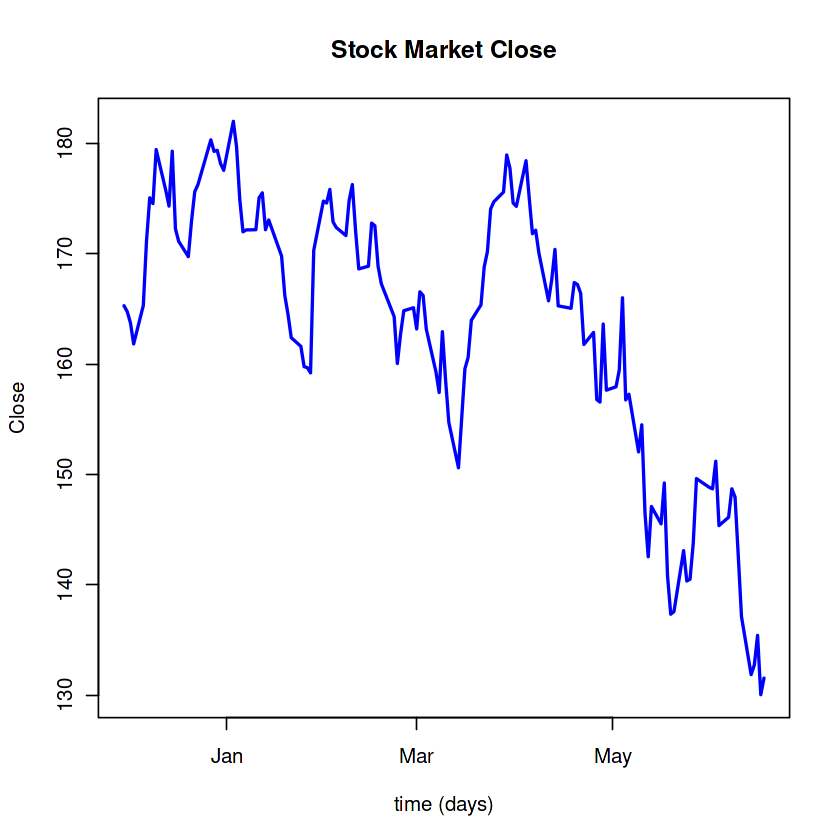

In [12]:
library(zoo)
AAPL_new <- AAPL %>% 
  mutate(Close = na.fill(Close, "extend")) # Fill the missing value with "extend"

AAPL_new %>%   
  tail(200) %>% 
  plot(type="l",
       col = "blue",
       lwd = 2,
       xlab = "time (days)",
       ylab = 'Close',
       main = "Stock Market Close") # Plot AAPL_new

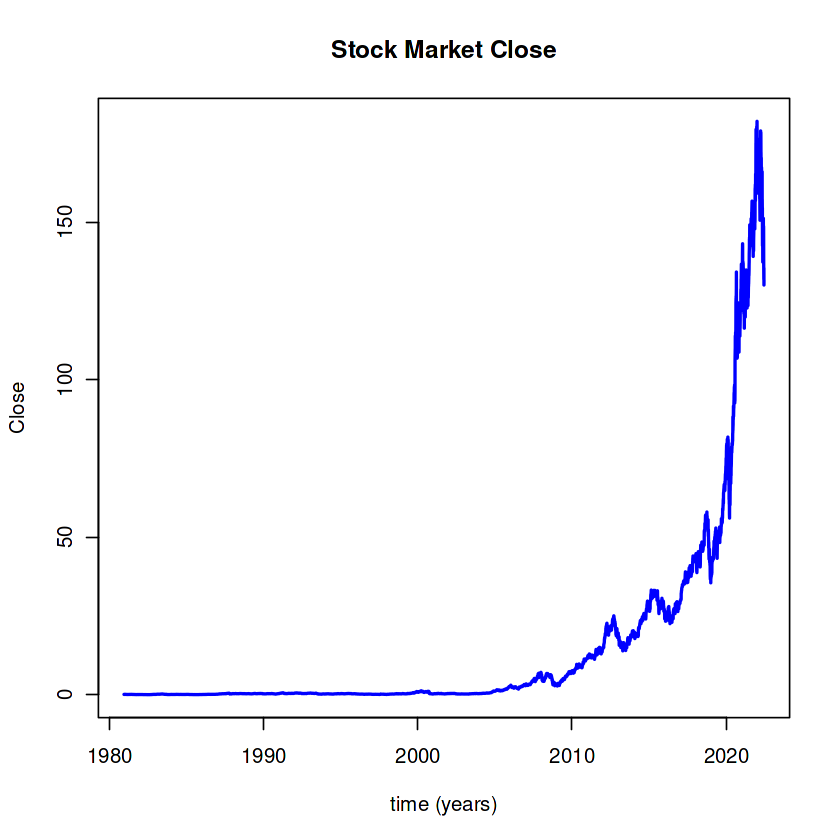

In [13]:
AAPL_new %>% 
    plot(type="l",
       col = "blue",
       lwd = 2,
       xlab = "time (years)",
       ylab = 'Close',
       main = "Stock Market Close")

#### **->The graph is now connected !**

# OUTLIERS CHECK :

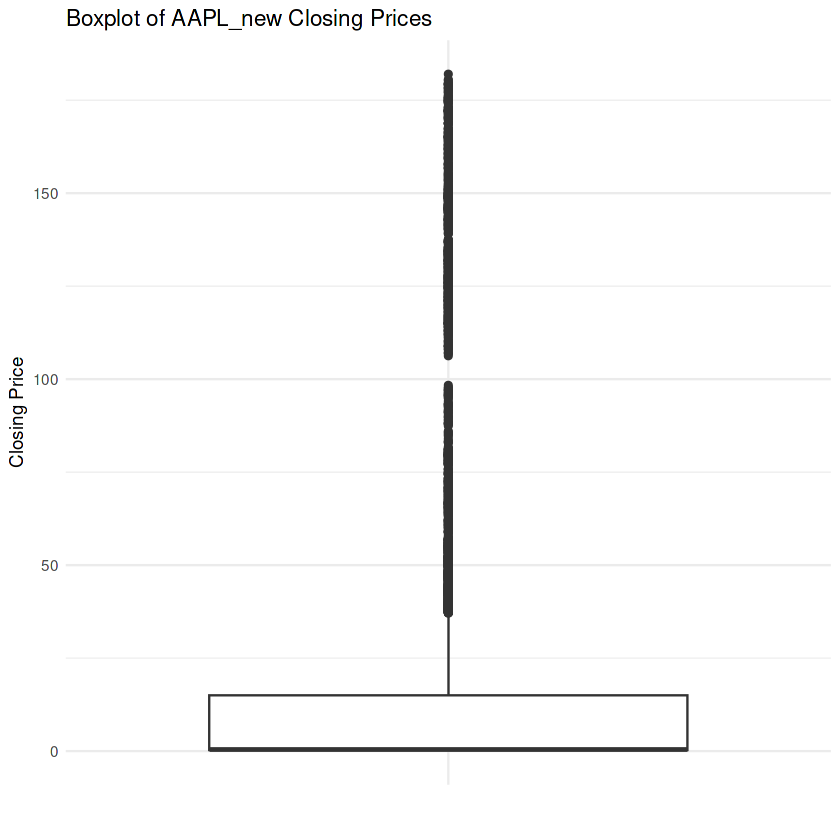

In [14]:
ggplot(data = AAPL_new, aes(x = "", y = Close)) +
  geom_boxplot() +
  ggtitle("Boxplot of AAPL_new Closing Prices") +
  ylab("Closing Price") +
  xlab("") +
  theme_minimal()

#### **->As we can see in the above boxplots, most of the values are seeming to be outliers on the upper side of the box plot. However, we cannot conclude them as outliers as these are the real time current stock prices.**

# DATA CLEANING :

In [15]:
class(AAPL_new)

[1] "tbl_df"     "tbl"        "data.frame"

## observation are day by day we change them to month by month :

In [16]:
APPL_m <- AAPL_new %>% 
    group_by(month = lubridate::floor_date(Date, "month")) %>%
    summarize(Close = mean(Close))

APPL_m %>% head()

month,Close
<date>,<dbl>
1980-12-01,0.1373046
1981-01-01,0.1421941
1981-02-01,0.1176292
1981-03-01,0.1108270
1981-04-01,0.1211123
1981-05-01,0.1306974


## change our data to Time Series :

In [17]:
AAPL_ts <- ts(
  data = APPL_m$Close,
  start = c(1980,12,01),
  frequency = 12
)

class(AAPL_ts)

[1] "ts"

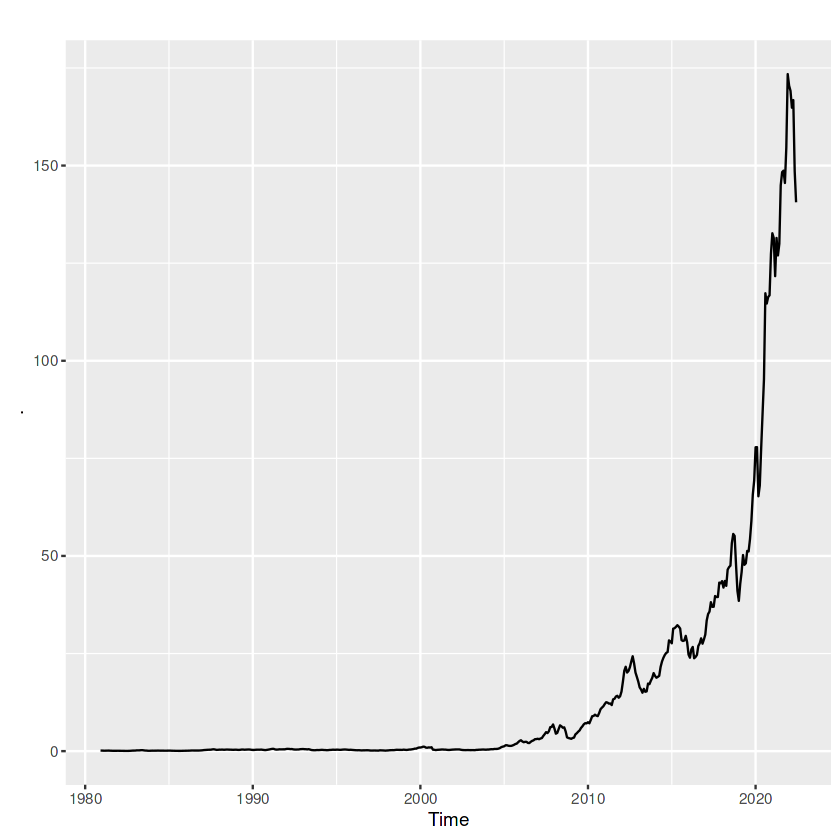

In [18]:
AAPL_ts %>% autoplot()

## we tried to use the years from 1980 to 2022 for our analysis. However, many aspects of that data were no longer relevant. Based on the graph above, we decided to focus only on the data from 2010 to 2022, providing us with 12 years of observation :

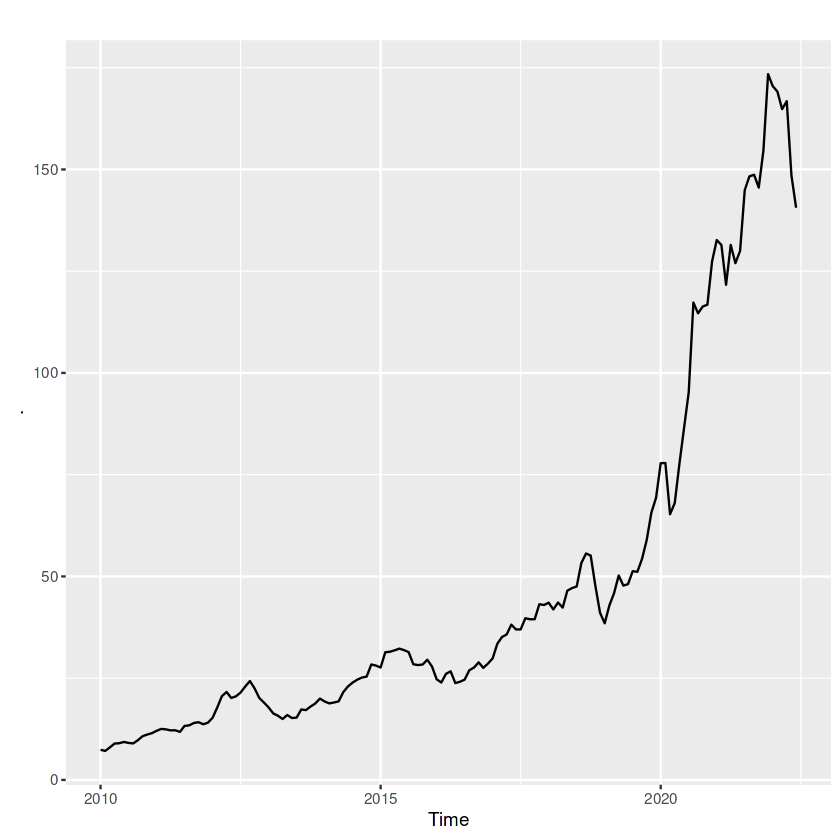

In [19]:
AAPL_w <- window(AAPL_ts, start = 2010) 

AAPL_w%>% autoplot()

# Cross Validation :

In [20]:
# test
AAPL_test <- tail(AAPL_w, 24)


# train
AAPL_train <- head(AAPL_w, -length(AAPL_test))

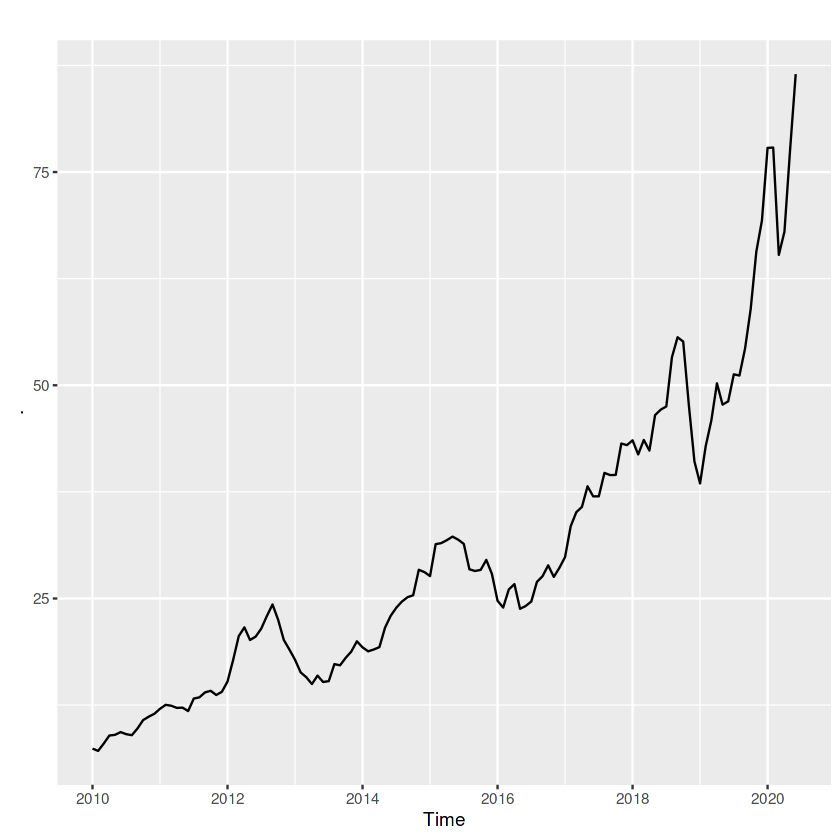

In [21]:
AAPL_train %>% autoplot()

#### **->The graph above show AAPL_train already splitted. As we can see the time (x-axis) has less observation than before.**

### Check AAPL_train trend and seasonal with decompose :

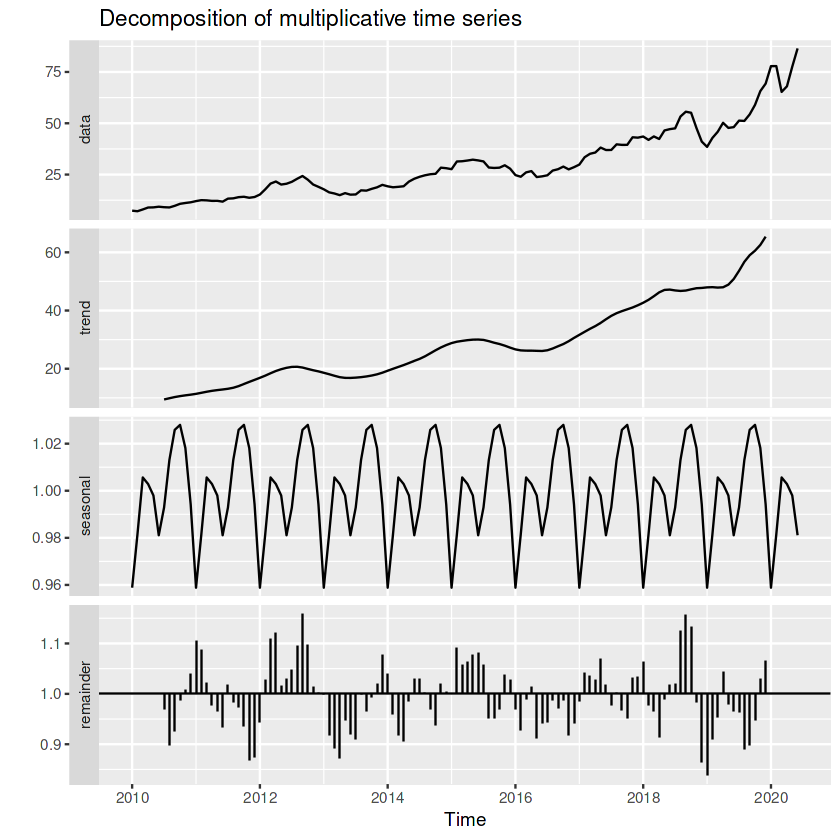

In [22]:
AAPL_dc <- decompose(AAPL_train, type = "multiplicative")
AAPL_dc %>% autoplot()

#### **->This data has an increasing trend from time to time. And also has seasonal. so we used SARIMA (Seasonal ARIMA) because: SARIMA models extend ARIMA to account for seasonal patterns in addition to trend.**

# SARIMA

## We test the stationary of data with adf.test() :

In [23]:
adf.test(AAPL_train)

Warning message in adf.test(AAPL_train):
“p-value greater than printed p-value”



	Augmented Dickey-Fuller Test

data:  AAPL_train
Dickey-Fuller = 0.54405, Lag order = 4, p-value = 0.99
alternative hypothesis: stationary


#### we get p-value = 0.99. This means fail to reject HO, so the data is not stationary.

## Differencing :

In [24]:
diff(AAPL_train, lag = 12) %>% 
  diff() %>% 
  adf.test()

Warning message in adf.test(.):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  .
Dickey-Fuller = -4.91, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


#### **->Now, the data is stasionary, with d = 1, D = 1**

# Model Fitting :

In [25]:
model_auto_sarima <- auto.arima(AAPL_train, seasonal = T)
model_auto_sarima

Series: AAPL_train 
ARIMA(0,1,1)(0,0,1)[12] with drift 

Coefficients:
         ma1     sma1   drift
      0.4258  -0.4266  0.5571
s.e.  0.0940   0.1144  0.1832

sigma^2 = 5.463:  log likelihood = -283.28
AIC=574.55   AICc=574.89   BIC=585.87

# Tuning the model manually

Step 1: Define the value of D.

Step 2: Define the value of d.

Step 3: Define the value of P and Q. 

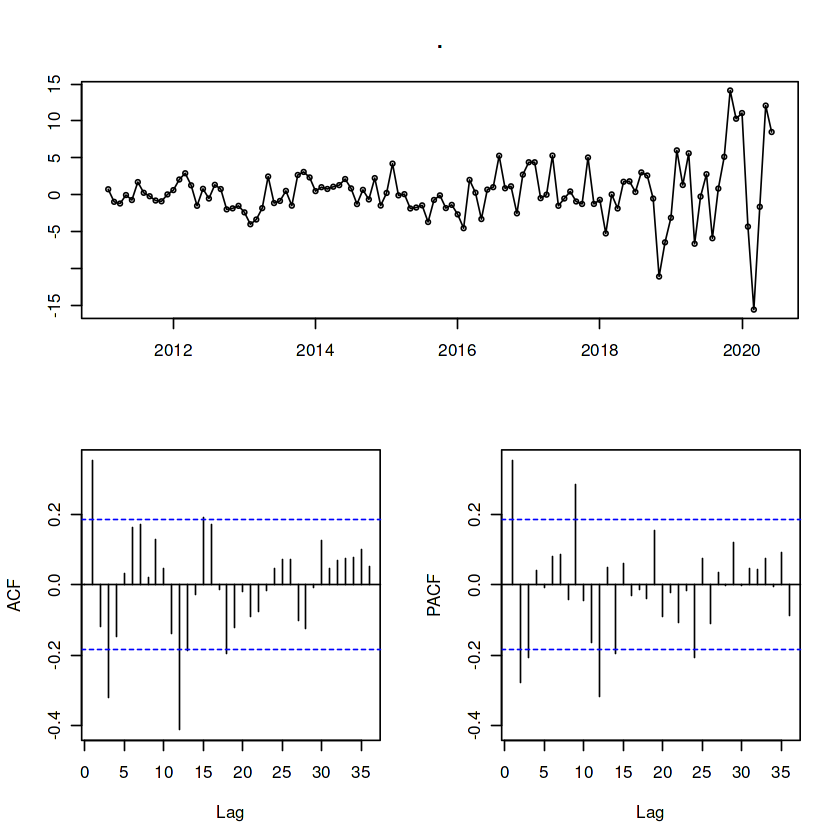

In [26]:
diff(AAPL_train, lag = 12) %>% 
  diff() %>% 
  tsdisplay(lag.max = 36)

For seasonal, determining P and Q we look at the lag multiples based on the frequency of our data.

    P : 0, 1, 2
    D : 1
    Q : 0, 1

for the whole data determining p and q we see the first 5 lags that come out.

    p : 0, 1 ,2, 3
    d : 1
    q : 0, 1, 2
The graph for seasonal

The combination of model that might be formed :


In [27]:
model_sarima_1 <- Arima(
  AAPL_train, order = c(0,1,0), seasonal = c(0,1,0))
model_sarima_2 <- Arima(
  AAPL_train, order = c(1,1,0), seasonal = c(0,1,0))
model_sarima_3 <- Arima(
  AAPL_train, order = c(2,1,0), seasonal = c(0,1,0))
model_sarima_4 <- Arima(
  AAPL_train, order = c(0,1,1), seasonal = c(0,1,0))
model_sarima_5 <- Arima(
  AAPL_train, order = c(1,1,1), seasonal = c(0,1,0))
model_sarima_6 <- Arima(
  AAPL_train, order = c(2,1,1), seasonal = c(0,1,0))

In [28]:
aic_values <- numeric(6)  # Assuming you have 6 models

# Loop through the models
for (i in 1:6) {
  model_name <- paste0("model_sarima_", i)
  aic_values[i] <- eval(parse(text = paste0(model_name, "$aic")))
}

# Display AIC values
aic_values

[1] 627.9755 614.1248 607.3965 611.1119 612.5639 605.9684

#### **->From 6 SARIMA models, with the least value of AIC is model_sarima_6. We still choose model_auto_sarima, because it still has the least value of AIC**

# Forecasting :

### **Forecast with model_auto_sarima for the next 24 months :**

In [29]:
forecast_AAPL_sarima <- forecast(
  object = model_auto_sarima,
  h = 24
) 

forecast_AAPL_sarima

         Point Forecast    Lo 80     Hi 80    Lo 95     Hi 95
Jul 2020       88.57132 85.57599  91.56666 83.99036  93.15229
Aug 2020       88.29391 83.07758  93.51024 80.31622  96.27160
Sep 2020       87.47726 80.73573  94.21878 77.16698  97.78753
Oct 2020       86.51932 78.53895  94.49969 74.31440  98.72424
Nov 2020       85.69997 76.64876  94.75118 71.85734  99.54260
Dec 2020       86.32323 76.31511  96.33135 71.01713 101.62933
Jan 2021       84.09560 73.21440  94.97680 67.45424 100.73696
Feb 2021       84.25919 72.56994  95.94845 66.38203 102.13636
Mar 2021       89.83250 77.38756 102.27745 70.79960 108.86541
Apr 2021       88.91064 75.75333 102.06795 68.78827 109.03301
May 2021       85.87427 72.04124  99.70731 64.71847 107.03007
Jun 2021       82.97098 68.49372  97.44823 60.82992 105.11203
Jul 2021       82.43946 67.65611  97.22281 59.83027 105.04864
Aug 2021       82.99652 68.01174  97.98130 60.07928 105.91376
Sep 2021       83.55358 68.37005  98.73712 60.33237 106.77480
Oct 2021

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


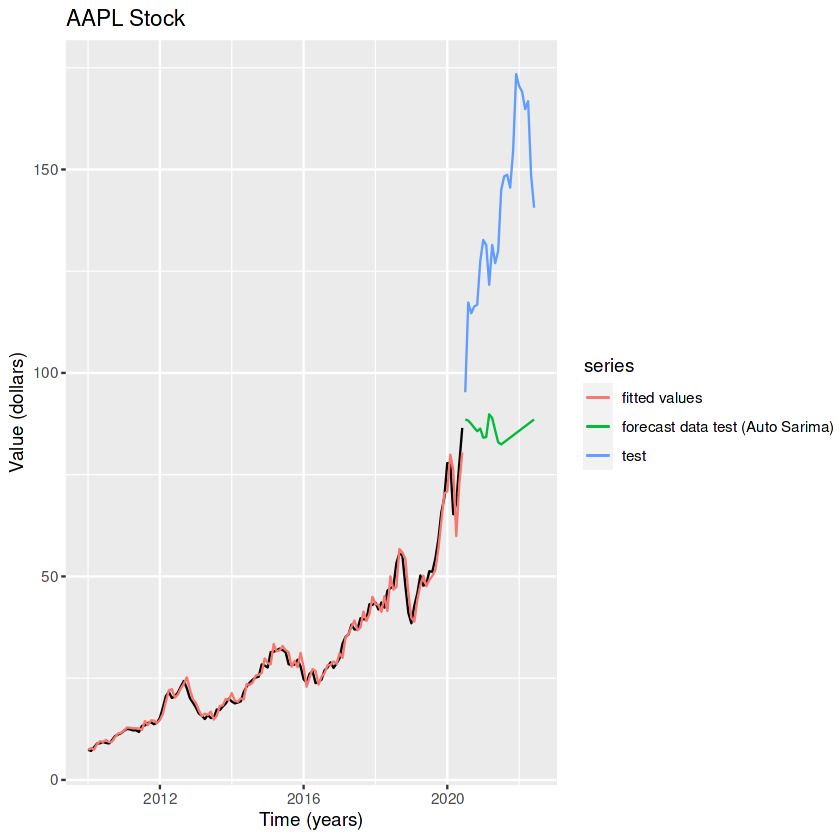

In [30]:
# Plotting the time series data, test data, fitted values, and forecast
AAPL_train %>% 
  autoplot() +
  autolayer(AAPL_test, series = 'test') +
  autolayer(fitted(model_auto_sarima), series = "fitted values") + 
  autolayer(forecast_AAPL_sarima$mean, series = "forecast data test (Auto Sarima)") +
  ggtitle("AAPL Stock") + 
  scale_x_continuous(name = "Time (years)") + 
  scale_y_continuous(name = "Value (dollars)")


In [31]:
# Check the structure of the model_auto_sarima$fitted object
str(model_auto_sarima$fitted)

# Verify the output of the SARIMA model
print(model_auto_sarima)


 Time-Series [1:126] from 2010 to 2020: 7.4 7.83 7.44 8.81 9.5 ...
Series: AAPL_train 
ARIMA(0,1,1)(0,0,1)[12] with drift 

Coefficients:
         ma1     sma1   drift
      0.4258  -0.4266  0.5571
s.e.  0.0940   0.1144  0.1832

sigma^2 = 5.463:  log likelihood = -283.28
AIC=574.55   AICc=574.89   BIC=585.87


#### **->This model can not predict the trend right. The predicted value is so far from the test data. My suspicion before actually turn out right.**

# MANUAL SARIMA

### **Forecast with model_sarima_6 for the next 24 months**

In [32]:
forecast_AAPL_sarima_manual <- forecast(
  object = model_sarima_6,
  h = 24
) 

forecast_AAPL_sarima_manual

         Point Forecast     Lo 80     Hi 80     Lo 95     Hi 95
Jul 2020       90.80738  86.38474  95.23002  84.04354  97.57122
Aug 2020       87.93078  80.22136  95.64021  76.14023  99.72133
Sep 2020       88.38712  78.65448  98.11977  73.50233 103.27192
Oct 2020       91.98675  81.12672 102.84679  75.37776 108.59575
Nov 2020       99.04682  87.44986 110.64377  81.31080 116.78283
Dec 2020      103.42345  91.17437 115.67252  84.69010 122.15679
Jan 2021      112.37318  99.43489 125.31147  92.58578 132.16059
Feb 2021      112.44965  98.78313 126.11617  91.54851 133.35079
Mar 2021       99.71399  85.32680 114.10117  77.71069 121.71729
Apr 2021      102.29676  87.23068 117.36284  79.25518 125.33834
May 2021      111.83614  96.13772 127.53457  87.82747 135.84481
Jun 2021      120.73993 104.44415 137.03571  95.81769 145.66218
Jul 2021      125.09894 106.58405 143.61382  96.78287 153.41501
Aug 2021      122.24501 100.86378 143.62623  89.54524 154.94477
Sep 2021      122.70289  98.95617 146.44

In [33]:
# Check the structure of the model_auto_sarima$fitted object
str(model_sarima_6$fitted)

# Verify the output of the SARIMA model
print(model_sarima_6)


 Time-Series [1:126] from 2010 to 2020: 7.4 7.13 7.99 8.93 9.01 ...
Series: AAPL_train 
ARIMA(2,1,1)(0,1,0)[12] 

Coefficients:
         ar1      ar2      ma1
      0.8128  -0.4323  -0.3849
s.e.  0.1712   0.0933   0.1712

sigma^2 = 11.91:  log likelihood = -298.98
AIC=605.97   AICc=606.34   BIC=616.88


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


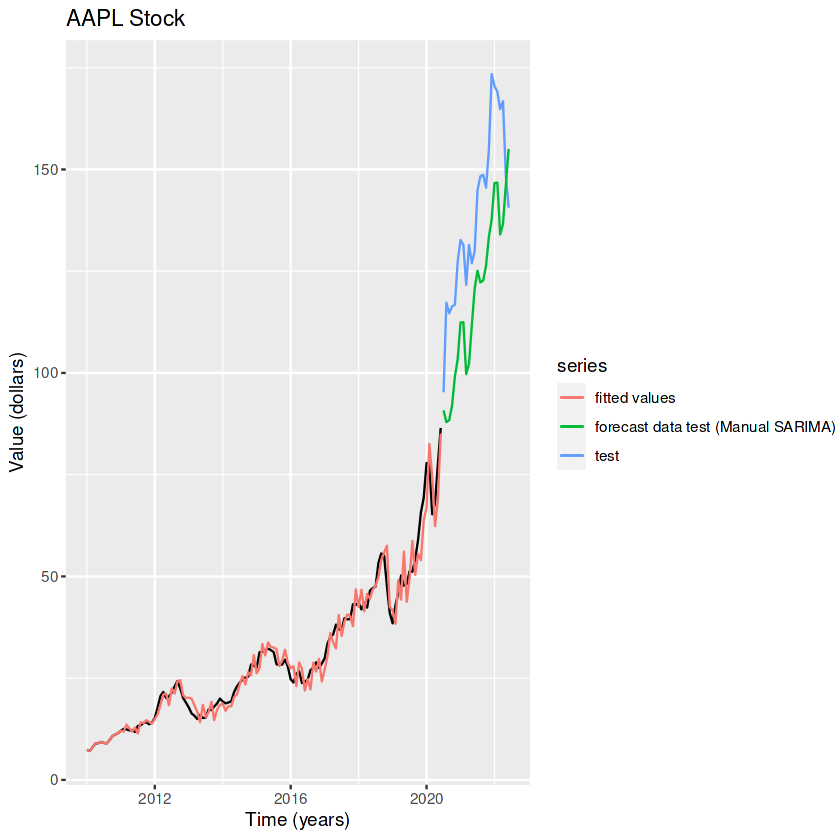

In [34]:
AAPL_train %>% 
  autoplot() +
  autolayer(AAPL_test, series = 'test') +
  autolayer(fitted(model_sarima_6), series = "fitted values") + 
  autolayer(forecast_AAPL_sarima_manual$mean, series = "forecast data test (Manual SARIMA)") +
  ggtitle("AAPL Stock") + 
  scale_x_continuous(name = "Time (years)") + 
  scale_y_continuous(name = "Value (dollars)")

### **->We can see that model_sarima_6 is forecasting better than the auto sarima model. Overall, the model can predict the train well and the model can follow the value of data test.**

# EVALUATION

In [35]:
accuracy(forecast_AAPL_sarima$mean, AAPL_test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,53.03586,57.04421,53.03586,36.66569,36.66569,0.7951778,5.344257


In [36]:
accuracy(forecast_AAPL_sarima_manual$mean, AAPL_test)

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,20.17145,22.78431,21.37533,14.50648,15.36277,0.2301237,2.341362


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


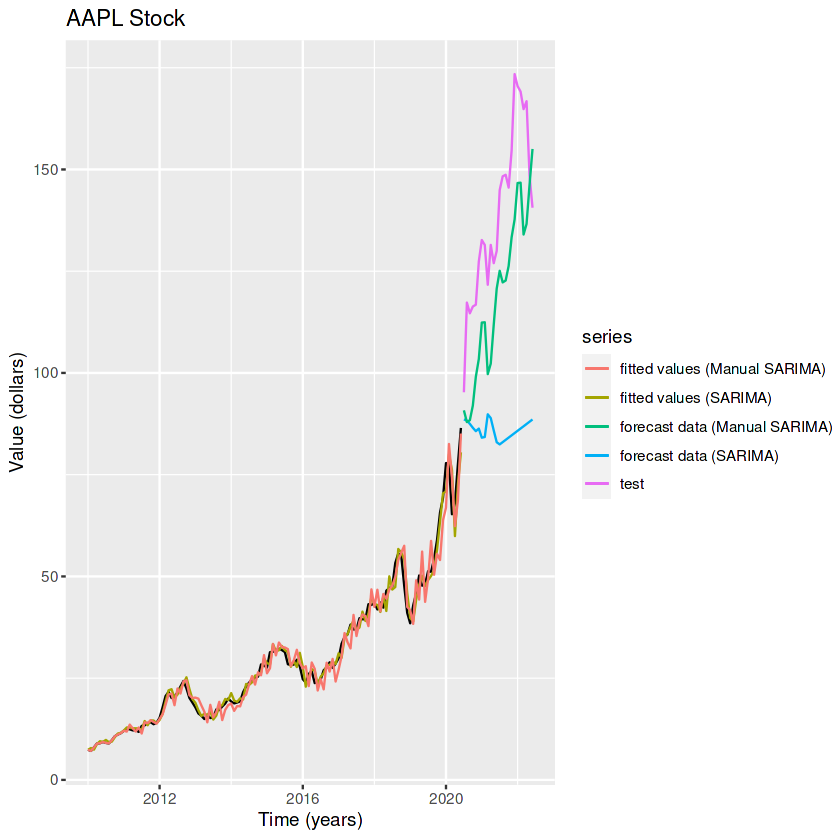

In [37]:
# Plotting the time series data, test data, fitted values, and forecast
AAPL_train %>% 
  autoplot() +
  autolayer(AAPL_test, series = "test") + 
  autolayer(fitted(forecast_AAPL_sarima), series = "fitted values (SARIMA)") + 
  autolayer(fitted(forecast_AAPL_sarima_manual), series = "fitted values (Manual SARIMA)") + 
  autolayer(forecast_AAPL_sarima$mean, series = "forecast data (SARIMA)") +
  autolayer(forecast_AAPL_sarima_manual$mean, series = "forecast data (Manual SARIMA)") + 
  ggtitle("AAPL Stock") + 
  scale_x_continuous(name = "Time (years)") + 
  scale_y_continuous(name = "Value (dollars)")



### **->From the 2 models we made, we can see Model Manual Sarima is relatively good model.  Because it can forecast when the stock value increasing or not.**